C:\ANACONDA\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
  File "C:\ANACONDA\Lib\site-packages\joblib\externals\loky\backend\context.py", line 199, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ANACONDA\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ANACONDA\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ANACONDA\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


+-------------+------------+------------+---------------------+---------------------+
|   Dataset   | Classifier | Technique  |      Comparison     |      Individual     |
+-------------+------------+------------+---------------------+---------------------+
|   Mozilla   |    KNN     |   TF-IDF   |  0.5219989278134151 |  0.5219989278134151 |
|   Mozilla   |     NB     |   TF-IDF   |  0.5270608959824347 |  0.5270608959824347 |
|   Mozilla   |     NN     |   TF-IDF   |  0.5297775394437397 |  0.5297775394437397 |
|   Mozilla   |     RF     |   TF-IDF   |  0.5299623000074919 |  0.5299623000074919 |
|   Mozilla   |    SVM     |   TF-IDF   |  0.5318990366764543 |  0.5318990366764543 |
|   Eclipse   |    KNN     |   TF-IDF   |  0.5183957555506833 |  0.5183957555506833 |
|   Eclipse   |     NB     |   TF-IDF   |  0.5226874526426254 |  0.5226874526426254 |
|   Eclipse   |     NN     |   TF-IDF   |  0.5241246091704038 |  0.5241246091704038 |
|   Eclipse   |     RF     |   TF-IDF   |  0.522718924

ValueError: x and y must have same first dimension, but have shapes (6,) and (5,)

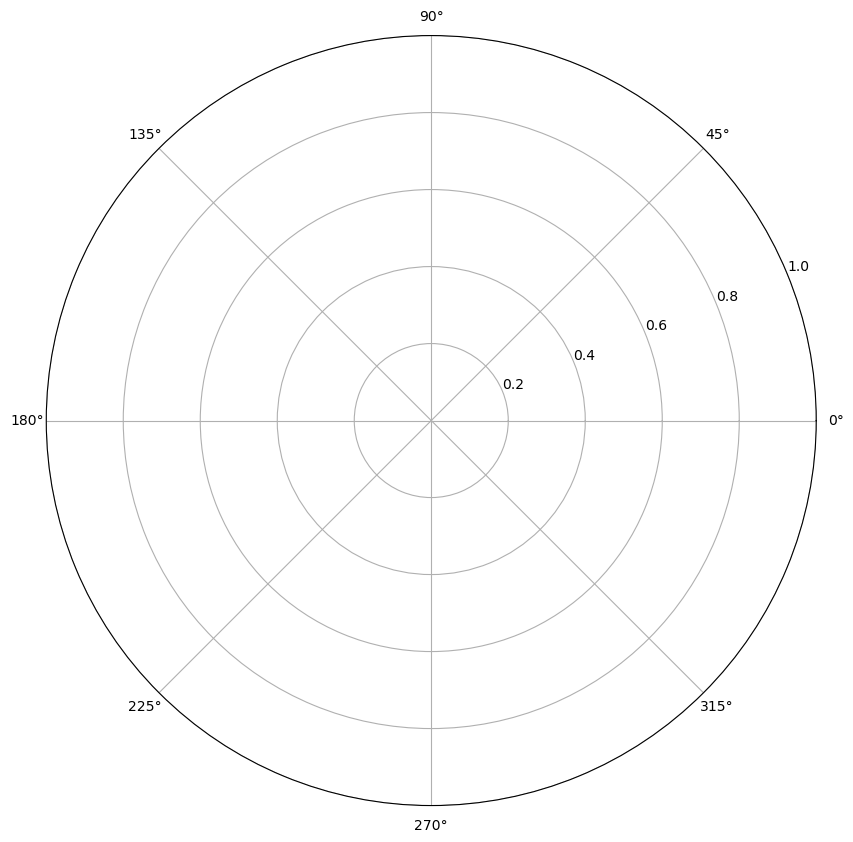

In [1]:
import numpy as np
import pandas as pd
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.exceptions import ConvergenceWarning
from warnings import simplefilter
import matplotlib.pyplot as plt

# Suppress warnings
simplefilter("ignore", category=UserWarning)
simplefilter("ignore", category=UserWarning, append=True)
simplefilter("ignore", category=ConvergenceWarning, append=True)

def load_and_preprocess_data(data_path):
    bug_reports = pd.read_csv(data_path)

    bug_reports['creation_date'] = pd.to_datetime(bug_reports['creation_date'], errors='coerce')
    bug_reports['resolution_date'] = pd.to_datetime(bug_reports['resolution_date'])
    bug_reports['bug_fix_time'] = (bug_reports['resolution_date'] - bug_reports['creation_date']).dt.days
    bug_reports = bug_reports.dropna(subset=['bug_fix_time', 'short_description'])

    threshold = 10
    bug_reports['bug_class'] = np.where(bug_reports['bug_fix_time'] <= threshold, 'short-lived', 'long-lived')

    return bug_reports

def extract_tfidf_features(bug_reports):
    tfidf_vectorizer = TfidfVectorizer(max_features=128, stop_words='english')
    tfidf_features = tfidf_vectorizer.fit_transform(bug_reports['short_description']).toarray()

    return tfidf_features

def extract_distilbert_features(bug_reports):
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertModel.from_pretrained('distilbert-base-uncased')

    def extract_distilbert_feature(text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

    distilbert_features = np.array(bug_reports['short_description'].apply(extract_distilbert_feature).tolist())
    distilbert_features = torch.tensor(distilbert_features)

    return distilbert_features

def extract_gcn_features(bug_reports):
    # Implement GCN feature extraction here
    # Placeholder code for illustration purposes
    gcn_features = np.random.rand(len(bug_reports), 128)
    return gcn_features

def extract_rnn_features(bug_reports):
    # Implement RNN feature extraction here
    # Placeholder code for illustration purposes
    rnn_features = np.random.rand(len(bug_reports), 128)
    return rnn_features

def train_and_evaluate_classifier(X_train, X_test, y_train, y_test, classifier, feature_type):
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)

    cm = confusion_matrix(y_test, predictions)
    balanced_accuracy = np.mean([cm[i, i] / np.sum(cm[i]) for i in range(len(np.unique(y_test)))])
    
    return balanced_accuracy

def print_results_table(datasets, classifiers, individual_results_tfidf, mean_accuracies_tfidf, individual_results_distilbert, mean_accuracies_distilbert, individual_results_gcn, mean_accuracies_gcn, individual_results_rnn, mean_accuracies_rnn):
    result_table = PrettyTable()

    # Add headers
    result_table.field_names = ["Dataset", "Classifier", "Technique", "Comparison", "Individual"]

    # Add data for TF-IDF
    best_acc_tfidf = -1
    best_acc_details_tfidf = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_tfidf[i][j] > best_acc_tfidf:
                best_acc_tfidf = mean_accuracies_tfidf[i][j]
                best_acc_details_tfidf = [datasets[i], classifiers[j], 'TF-IDF', best_acc_tfidf, individual_results_tfidf[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'TF-IDF', mean_accuracies_tfidf[i][j], individual_results_tfidf[i][j]])

    # Add data for DistilBERT
    best_acc_distilbert = -1
    best_acc_details_distilbert = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_distilbert[i][j] > best_acc_distilbert:
                best_acc_distilbert = mean_accuracies_distilbert[i][j]
                best_acc_details_distilbert = [datasets[i], classifiers[j], 'DistilBERT', best_acc_distilbert, individual_results_distilbert[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'DistilBERT', mean_accuracies_distilbert[i][j], individual_results_distilbert[i][j]])

    # Add data for GCN
    best_acc_gcn = -1
    best_acc_details_gcn = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_gcn[i][j] > best_acc_gcn:
                best_acc_gcn = mean_accuracies_gcn[i][j]
                best_acc_details_gcn = [datasets[i], classifiers[j], 'GCN', best_acc_gcn, individual_results_gcn[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'GCN', mean_accuracies_gcn[i][j], individual_results_gcn[i][j]])

    # Add data for RNN
    best_acc_rnn = -1
    best_acc_details_rnn = []
    for i in range(len(datasets)):
        for j in range(len(classifiers)):
            if mean_accuracies_rnn[i][j] > best_acc_rnn:
                best_acc_rnn = mean_accuracies_rnn[i][j]
                best_acc_details_rnn = [datasets[i], classifiers[j], 'RNN', best_acc_rnn, individual_results_rnn[i][j]]

            result_table.add_row([datasets[i], classifiers[j], 'RNN', mean_accuracies_rnn[i][j], individual_results_rnn[i][j]])

    # Print the table
    print(result_table)

    # Print the table with best accuracy details
    best_acc_table = PrettyTable()
    best_acc_table.field_names = ["Dataset", "Classifier", "Technique", "Best Accuracy", "Details"]
    best_acc_table.add_row(best_acc_details_tfidf)
    best_acc_table.add_row(best_acc_details_distilbert)
    best_acc_table.add_row(best_acc_details_gcn)
    best_acc_table.add_row(best_acc_details_rnn)

    print("\nBest Accuracy Details:")
    print(best_acc_table)

def plot_spider_chart(classifiers, datasets, accuracies_tfidf, accuracies_distilbert, accuracies_gcn, accuracies_rnn):
    N = len(classifiers)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for i in range(len(datasets)):
        values_tfidf = accuracies_tfidf[i]
        values_distilbert = accuracies_distilbert[i]
        values_gcn = accuracies_gcn[i]
        values_rnn = accuracies_rnn[i]
        values_tfidf += values_tfidf[:1]
        values_distilbert += values_distilbert[:1]
        values_gcn += values_gcn[:1]
        values_rnn += values_rnn[:1]

        ax.plot(angles, values_tfidf, label=f'{datasets[i]} TF-IDF')
        ax.plot(angles, values_distilbert, label=f'{datasets[i]} DistilBERT')
        ax.plot(angles, values_gcn, label=f'{datasets[i]} GCN')
        ax.plot(angles, values_rnn, label=f'{datasets[i]} RNN')

    ax.fill(angles, values_tfidf, alpha=0.1)
    ax.fill(angles, values_distilbert, alpha=0.1)
    ax.fill(angles, values_gcn, alpha=0.1)
    ax.fill(angles, values_rnn, alpha=0.1)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classifiers)

    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title('Comparison of Classifiers Across Datasets')
    plt.show()

# Define datasets and classifiers
datasets = ['Mozilla', 'Eclipse', 'GCC', 'GNOME', 'WineHQ', 'FreeDesktop']
classifiers = ['KNN', 'NB', 'NN', 'RF', 'SVM']

# Initialize empty lists for individual and mean accuracies
individual_results_tfidf = []
individual_results_distilbert = []
individual_results_gcn = []
individual_results_rnn = []

mean_accuracies_tfidf = []
mean_accuracies_distilbert = []
mean_accuracies_gcn = []
mean_accuracies_rnn = []

# Load and preprocess data for different projects
data_paths = [
    r'C:\Users\hp\Desktop\New folder (2)\mozilla_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\eclipse_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\gcc_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\gnome_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\winehq_bug_report_data.csv',
    r'C:\Users\hp\Desktop\New folder (2)\freedesktop_bug_report_data.csv'
]
#
for data_path in data_paths:
    bug_reports = load_and_preprocess_data(data_path)

    X_tfidf = extract_tfidf_features(bug_reports)
    X_distilbert = extract_distilbert_features(bug_reports)
    X_gcn = extract_gcn_features(bug_reports)
    X_rnn = extract_rnn_features(bug_reports)
    y = bug_reports['bug_class']

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    accuracies_tfidf = []
    accuracies_distilbert = []
    accuracies_gcn = []
    accuracies_rnn = []

    for train_index, test_index in skf.split(X_tfidf, y):
        X_train_tfidf, X_test_tfidf = X_tfidf[train_index], X_tfidf[test_index]
        y_train_tfidf, y_test_tfidf = y.iloc[train_index], y.iloc[test_index]

        X_train_distilbert, X_test_distilbert = X_distilbert[train_index], X_distilbert[test_index]
        y_train_distilbert, y_test_distilbert = y.iloc[train_index], y.iloc[test_index]

        X_train_gcn, X_test_gcn = X_gcn[train_index], X_gcn[test_index]
        y_train_gcn, y_test_gcn = y.iloc[train_index], y.iloc[test_index]

        X_train_rnn, X_test_rnn = X_rnn[train_index], X_rnn[test_index]
        y_train_rnn, y_test_rnn = y.iloc[train_index], y.iloc[test_index]

        scaler = MinMaxScaler()
        X_train_distilbert = scaler.fit_transform(X_train_distilbert)
        X_test_distilbert = scaler.transform(X_test_distilbert)
        X_train_gcn = scaler.fit_transform(X_train_gcn)
        X_test_gcn = scaler.transform(X_test_gcn)
        X_train_rnn = scaler.fit_transform(X_train_rnn)
        X_test_rnn = scaler.transform(X_test_rnn)

        accuracies_tfidf.append([
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                KNeighborsClassifier(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                MultinomialNB(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                MLPClassifier(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                RandomForestClassifier(),
                'TF-IDF'
            ),
            train_and_evaluate_classifier(
                X_train_tfidf,
                X_test_tfidf,
                y_train_tfidf,
                y_test_tfidf,
                SVC(),
                'TF-IDF'
            )
        ])

        accuracies_distilbert.append([
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                KNeighborsClassifier(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                MultinomialNB(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                MLPClassifier(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                RandomForestClassifier(),
                'DistilBERT'
            ),
            train_and_evaluate_classifier(
                X_train_distilbert,
                X_test_distilbert,
                y_train_distilbert,
                y_test_distilbert,
                SVC(),
                'DistilBERT'
            )
        ])

        accuracies_gcn.append([
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                KNeighborsClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                KNeighborsClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                MLPClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                RandomForestClassifier(),
                'GCN'
            ),
            train_and_evaluate_classifier(
                X_train_gcn,
                X_test_gcn,
                y_train_gcn,
                y_test_gcn,
                SVC(),
                'GCN'
            )
        ])

        accuracies_rnn.append([
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                KNeighborsClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                KNeighborsClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                MLPClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                RandomForestClassifier(),
                'RNN'
            ),
            train_and_evaluate_classifier(
                X_train_rnn,
                X_test_rnn,
                y_train_rnn,
                y_test_rnn,
                SVC(),
                'RNN'
            )
        ])

    individual_results_tfidf.append(np.mean(accuracies_tfidf, axis=0))
    individual_results_distilbert.append(np.mean(accuracies_distilbert, axis=0))
    individual_results_gcn.append(np.mean(accuracies_gcn, axis=0))
    individual_results_rnn.append(np.mean(accuracies_rnn, axis=0))

    mean_accuracies_tfidf.append(np.mean(accuracies_tfidf, axis=0))
    mean_accuracies_distilbert.append(np.mean(accuracies_distilbert, axis=0))
    mean_accuracies_gcn.append(np.mean(accuracies_gcn, axis=0))
    mean_accuracies_rnn.append(np.mean(accuracies_rnn, axis=0))

# Print the results table
print_results_table(datasets, classifiers, individual_results_tfidf, mean_accuracies_tfidf, individual_results_distilbert, mean_accuracies_distilbert, individual_results_gcn, mean_accuracies_gcn, individual_results_rnn, mean_accuracies_rnn)

# Plot the spider chart
plot_spider_chart(classifiers, datasets, mean_accuracies_tfidf, mean_accuracies_distilbert, mean_accuracies_gcn, mean_accuracies_rnn)
